In [7]:
import pandas as pd
import numpy as np
import sqlite3
import sklearn
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
from csv import writer
from datetime import datetime, timedelta
from sklearn.covariance import LedoitWolf
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.factory import get_selection
from pymoo.core.selection import Selection
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination

In [8]:
# Specify list of start and end date for historical periods to use in paramater estimation for desired number of optimisations

history_start_list = ['2017-01-01','2018-01-01','2019-01-01','2020-01-01','2021-01-01']
history_end_list = ['2018-01-01','2019-01-01','2020-01-01','2021-01-01','2022-01-01']

return_difference_list = []
result_list = []

In [9]:
for count, value in enumerate(history_start_list):



    history_start_date = value
    history_end_date = history_end_list[count]

    cardinality_constraint = 5
    cardinality_threshold = 0
    max_asset_weight = 0.3
    population_size = 100
    number_of_generations = 10000
    portfolio_holding_period = 15 # Time to hold selected portfolio in calendar days



    conn = sqlite3.connect('continuous_futures.db')

    excluded_assets = ('CME_SP1_FW', 'CME_DA1_FW', 'CME_RS11_FW')

    assets = pd.read_sql(f"SELECT date, quandl_code, settle FROM \
    Continuous_Futures WHERE method = 'FW' AND depth = 1 AND exchange = 'CME' AND quandl_code NOT IN {excluded_assets} AND \
    date BETWEEN '{history_start_date}' AND '{history_end_date}'", conn)

    conn.close()

    assets.set_index('date', inplace = True)
    assets_p = assets.pivot(columns="quandl_code", values="settle")
    assets_p.sort_values(by = 'date', ascending = False, inplace = True)

    # Check for any extreme proportion of missing prices within chosen range for each asset
    # print(assets_p.isna().sum() / len(assets_p)) 

    asset_list1 = assets_p.columns[0:].to_list()
    daily_returns = pd.DataFrame()

    assets_p.dropna(inplace = True)

    for i in asset_list1:
        daily_returns[f'{i}_long'] = ((assets_p[f'{i}'] - assets_p[f'{i}'].shift(-1)) / assets_p[f'{i}'].shift(-1))
        daily_returns[f'{i}_short'] = ((assets_p[f'{i}'].shift(-1) - assets_p[f'{i}']) / assets_p[f'{i}'].shift(-1))

    daily_returns.dropna(inplace = True)

    # Create vector of mean daily return for each asset, long & short

    mean_return = []

    for i in asset_list1:
        long_return = daily_returns[f'{i}_long'].mean()
        short_return = daily_returns[f'{i}_short'].mean()
        mean_return.append(long_return)
        mean_return.append(short_return)

    mreturn = np.array(mean_return)

    output_csv_name = f"history{value}to{history_end_date}_pop{population_size}_ngen{number_of_generations}_K{cardinality_constraint}_Max{max_asset_weight}_{len(mreturn) / 2}assets_{count}"

    # Sample covariance matrix
    # covariance_matrix = daily_returns.cov().to_numpy()

    # Apply Ledoit Wolf shrinkage to improve covariance matrix estimation
    LW_shrinkage = LedoitWolf().fit(daily_returns)
    cvm = LW_shrinkage.covariance_

    # Generated initial population for cardinality & maximum weighting constrained test

    maxweight_cardinality_list = []

    while len(maxweight_cardinality_list) < population_size:
        x = np.random.dirichlet(np.ones(cardinality_constraint), size = 1)
        if np.all(x <= max_asset_weight):
            maxweight_cardinality_list.append(x)

    initial_pop = np.zeros((population_size, len(mreturn)))

    for i in range(population_size):
        initial_pop[i,:cardinality_constraint] = maxweight_cardinality_list[i]
        np.random.shuffle(initial_pop[i])

    # Sample population to satisfy cardinality constraint alone

    # initial_pop = np.zeros((population_size, len(mreturn)))

    # for i in range(population_size):
    #     initial_pop[i,:cardinality_constraint] = np.random.rand(cardinality_constraint)
    #     initial_pop[i] = initial_pop[i] / np.sum(initial_pop[i])
    #     np.random.shuffle(initial_pop[i])


    class MyProblem(ElementwiseProblem):

        def __init__(self, mreturn, cvm):
            super().__init__(n_var = len(mreturn),
                            n_obj = 2,
                            n_constr = 2,
                            xl = np.array([0 for asset in mreturn]),
                            xu = np.array([1 for asset in mreturn]))

            self.mreturn = mreturn
            self.cvm = cvm
            self.K = cardinality_constraint

        def _evaluate(self, x, out, *args, **kwargs):
            
            # Normalise asset weightings to collectively sum to 1
            x = x / np.sum(x) 

            # Risk/variance objective function
            f1 = np.dot(x, (np.dot(self.cvm, x))) 
            
            # Mean return objective function
            f2 = -(np.dot(x, self.mreturn))

            # Cardinality Constraint
            g1 = sum(asset > cardinality_threshold for asset in x) - self.K

            # Require asset weightings sum to 1 +/- threshold.  Unnecessary with normalisation
            # g2 = ((sum(x) - 1)) ** 2 - asset_sum_threshold 
            
            # Maximum asset weighting constraint
            g3 = (max((asset - max_asset_weight) for asset in x))

            # Minimum asset weighting constraint
            # g4 = (max((min_asset_weight - asset) for asset in x if asset > cardinality_threshold))

            # Pre-assignment constraint
            #g5 = 0.25 - x[16]
            
            out["F"] = np.column_stack([f1, f2])
            out["G"] = [g1, g3]


    problem = MyProblem(mreturn, cvm)


    algorithm = NSGA2(pop_size = population_size, sampling = initial_pop)


    res = minimize(problem,
                algorithm,
                ("n_gen", number_of_generations),
                verbose = True,
                save_history = False,
                seed = None)

    result_list.append(res.F)

    # Create CSV to import for headers of optimised portfolio output

    asset_headings = list(daily_returns.columns)

    asset_headings.append("Variance")
    asset_headings.append("Mean Return")

    with open(f"{output_csv_name}.csv", 'w', newline = '') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(asset_headings)
        f_object.close()

    result_X_normalised = [x / np.sum(x) for x in res.X] # normalise output portfolio compositions that make up non-dominated solutions to obtain correct weightings

    # Convert mean return objective values which have been minimised to positive

    for i in res.F:
        i[1] *= (-1)

    result_x_list = []

    for count, value in enumerate(result_X_normalised):
        for i in value:
            result_x_list.append(i)
        for j in res.F[count]:
            result_x_list.append(j)

    chunked_result_x_list = []
    chunk_size = len(asset_headings)

    for i in range(0, len(result_x_list), chunk_size):
        chunked_result_x_list.append(result_x_list[i:i + chunk_size])

    with open(f'{output_csv_name}.csv', 'a', newline='') as f_object:
        writer_object = writer(f_object)
        for i in chunked_result_x_list:
            writer_object.writerow(i)
        f_object.close()

    print(history_end_date)
    holding_period_start = (datetime.strptime(history_end_date, '%Y-%m-%d') + timedelta(days = 1)).strftime('%Y-%m-%d')
    holding_period_end = (datetime.strptime(history_end_date, '%Y-%m-%d') + timedelta(days = portfolio_holding_period)).strftime('%Y-%m-%d')

    conn = sqlite3.connect('continuous_futures.db')

    portfolio_results = pd.read_sql(f"SELECT date, quandl_code, settle FROM \
    Continuous_Futures WHERE method = 'FW' AND depth = 1 AND exchange = 'CME' \
    AND date BETWEEN '{holding_period_start}' AND '{holding_period_end}'", conn)

    conn.close()

    portfolio_results.set_index('date', inplace = True)
    portfolio_results = portfolio_results.pivot(columns="quandl_code", values = "settle")
    portfolio_results.sort_values(by = 'date', ascending = False, inplace = True)

    portfolio_assets_list = portfolio_results.columns[0:].to_list()
    portfolio_returns = pd.DataFrame()

    for i in portfolio_assets_list:
        portfolio_returns[f'{i}_long'] = ((portfolio_results[f'{i}'] - portfolio_results[f'{i}'].shift(-1)) / portfolio_results[f'{i}'].shift(-1))
        portfolio_returns[f'{i}_short'] = ((portfolio_results[f'{i}'].shift(-1) - portfolio_results[f'{i}']) / portfolio_results[f'{i}'].shift(-1))

    portfolio_returns.dropna(inplace = True)

    pf_mean_return = []

    for i in asset_list1:
        long_return = portfolio_returns[f'{i}_long'].mean()
        short_return = portfolio_returns[f'{i}_short'].mean()
        pf_mean_return.append(long_return)
        pf_mean_return.append(short_return)

    pf_er_list = []

    for i in result_X_normalised:
        pf_er_list.append(sum(i * pf_mean_return))
        (sum(i * pf_mean_return))


    total_results = pd.read_csv(f"{output_csv_name}.csv")

    total_results[f'{portfolio_holding_period} Day Return'] = pf_er_list
    total_results['Difference vs. Mean Return'] = total_results[f'{portfolio_holding_period} Day Return'] - total_results['Mean Return']
    return_difference_list.append(total_results['Difference vs. Mean Return'].mean())

    total_results.to_csv(f'{output_csv_name}.csv', index = False)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      8 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |      300 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |      400 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      500 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      600 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |      700 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      800 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      900 |      8 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |     1000 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0111001631 |             f

In [10]:
# Save the set of non-dominated solution objective values from each test

for count, value in enumerate(result_list):
    np.savetxt(f"ResultsF_{count}.csv", value, delimiter = ',')

#### Scatter plot of Non-Dominated Solution set from Each Test

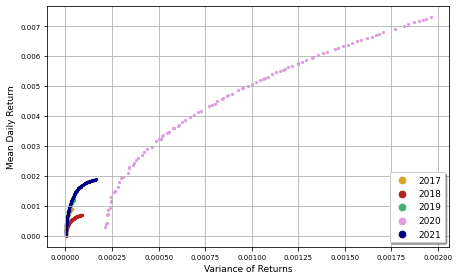

In [11]:
colour_list = ['goldenrod', 'firebrick', 'mediumseagreen', 'plum', 'navy']
label_list = ['2017', '2018', '2019', '2020', '2021']

plt.rc('font', size = 10)
plt.rc('axes', titlesize = 10, labelsize = 9)
plt.rc('axes', facecolor = 'white')
plt.rc('xtick', labelsize = 7)
plt.rc('ytick', labelsize = 7)
plt.figure(figsize=(6.5, 4), facecolor = 'white')

for count, value in enumerate(result_list):
        plt.scatter((value[:, 0]), (value[:, 1]), s = 5, marker = "o", facecolors = colour_list[count], label = label_list[count])

plt.xlabel("Variance of Returns")
plt.ylabel("Mean Daily Return")
plt.legend(fancybox = True, shadow = True, fontsize = 9, markerscale = 3, loc = 4)
plt.grid()
plt.tight_layout()
plt.savefig("Optimisation_Paretofront.png", dpi = 500)